In [1]:
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
datapath = 'Data/cell_images/training_set/BW/'

In [3]:
import lib.dataloader
from Model.Predictor_Parallel import Predictor

/Users/HarveyYan/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
BATCH_SIZE = 200
N_EMB = 3 # 3 channels for augmented images
DEVICES = ['/cpu:0']
digits_limits = 8

# defining the hyperparameters
HParams = ['arch', 'use_bn', 'use_lstm', 'nb_layers', 'filter_size', 'output_dim',
           'learning_rate', 'use_clr', 'use_momentum', 'length_obj_ratio']

arch = 1
use_bn = True
use_lstm = True
nb_layers = 8
filter_size = 3
output_dim = 16
learning_rate = 2e-4
use_clr = True
use_momentum = False
length_obj_ratio = 0.

hp = {}
for param in HParams:
    hp[param] = eval(param)
    
lib.dataloader.digits_limit = digits_limits
lib.dataloader.nb_channels = N_EMB

In [5]:
dataset = lib.dataloader.load_ocr_dataset()

dataset size 7497
training set 6748
test set 749


(34, 84, 3)


(-0.5, 83.5, 33.5, -0.5)

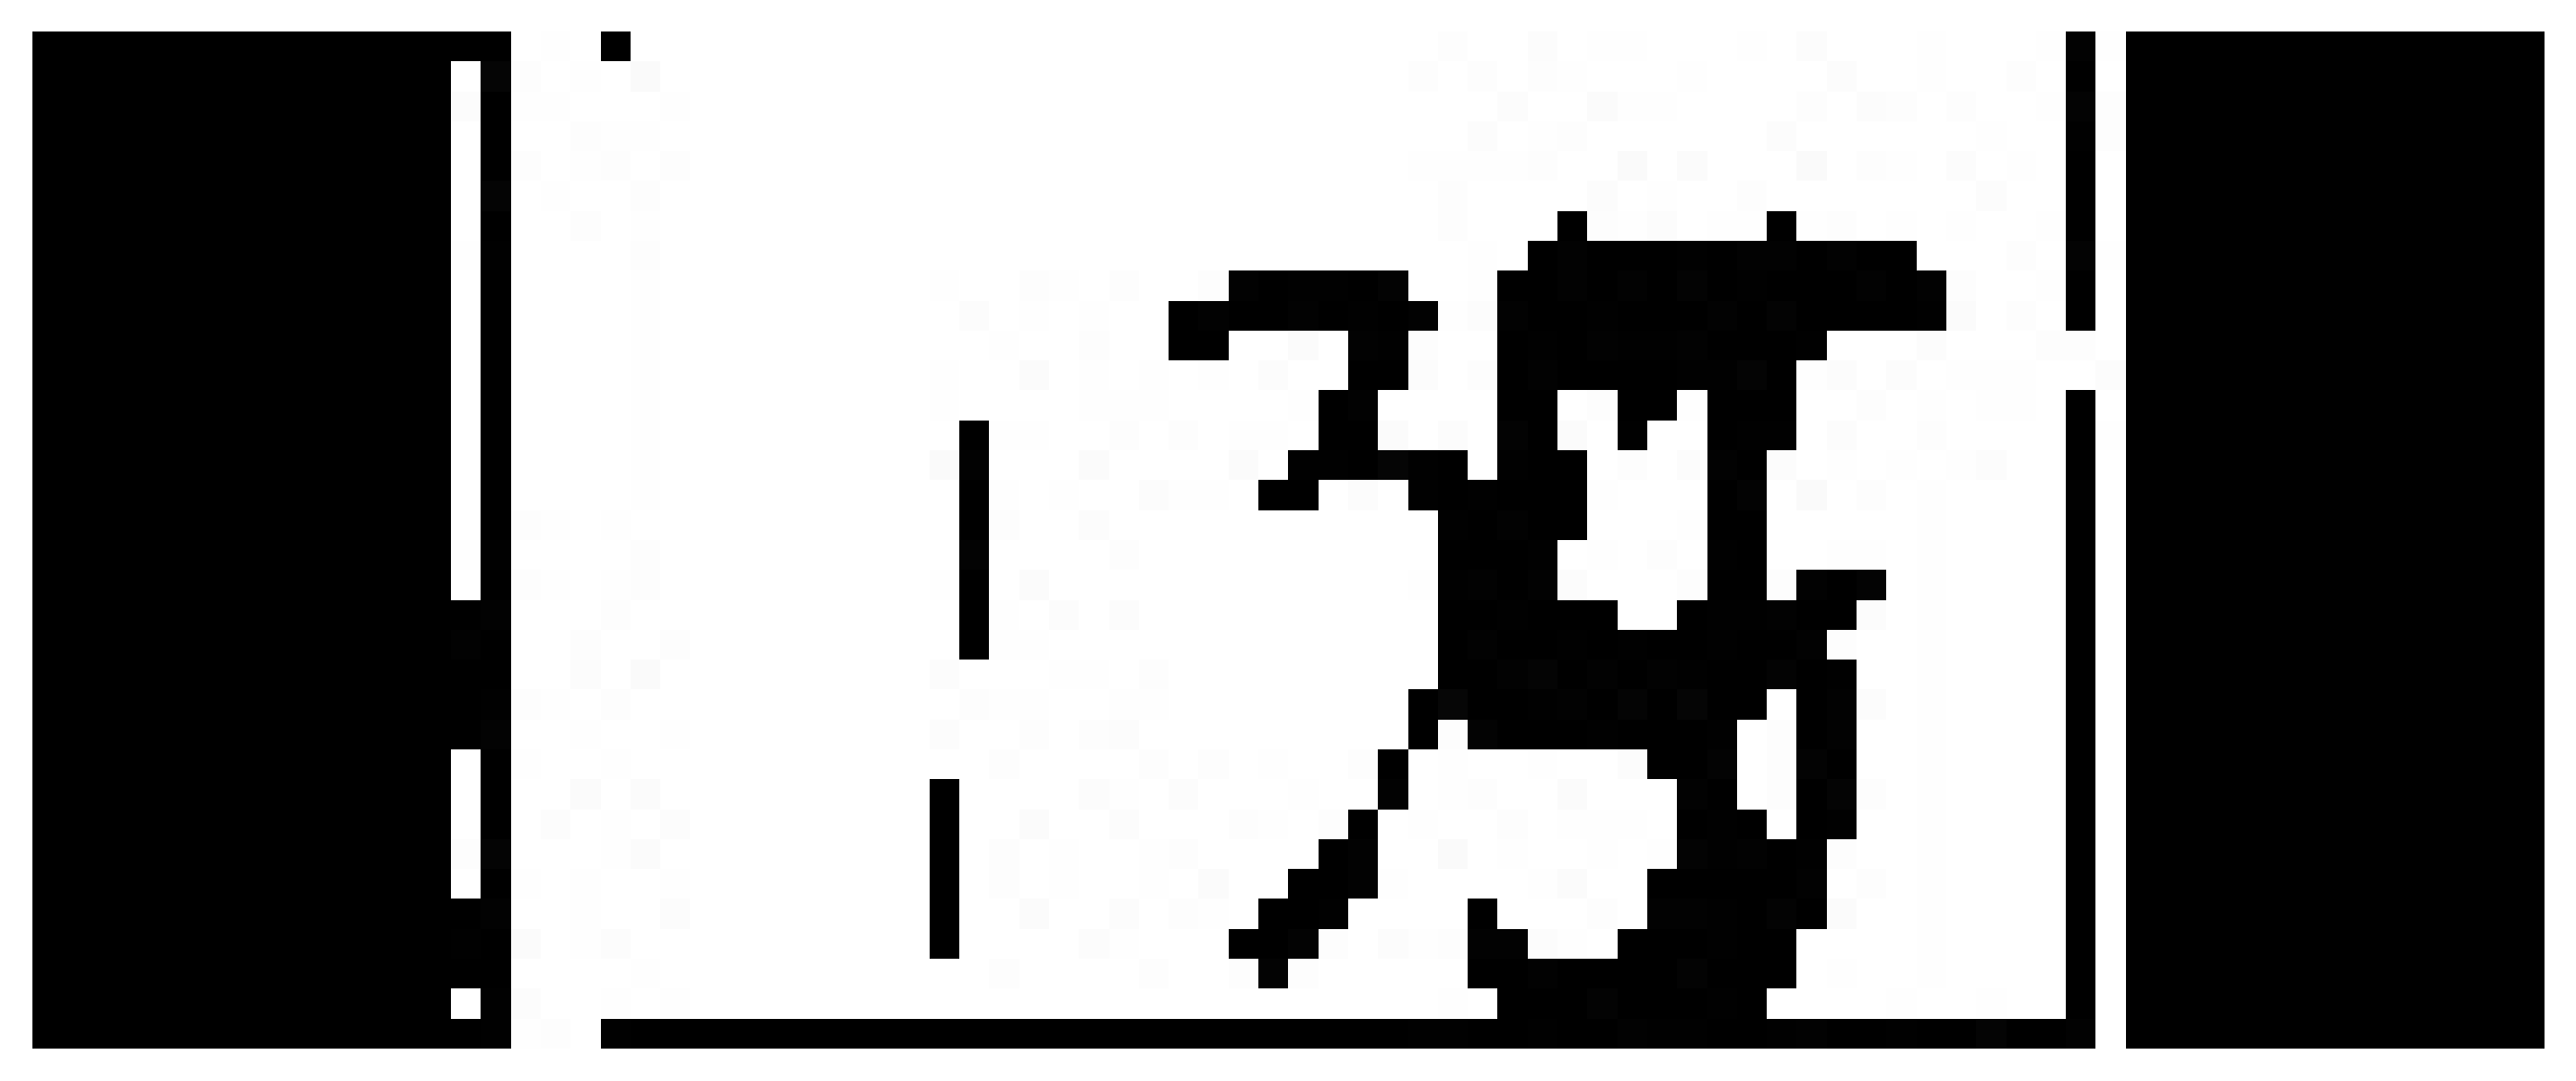

In [6]:
print(dataset['test_images'][0].shape)
plt.imshow(dataset['test_images'][0], cmap='gray')
plt.axis('off')

In [7]:
dataset['test_ids'][0]

'5985.jpg'

In [9]:
[lib.dataloader.all_allowed_characters[idx] for idx in dataset['test_targets'][0]]

['1', '3', '5', '!', '!', '!', '!', '!']

'!' is a dummy character we used to pad sequences to same length. Even though RNN is dynamic, for batch operation it's unrolled for a fixed/maximal steps

In [10]:
DEVICES

['/cpu:0']

In [11]:
N_CLASS = len(lib.dataloader.all_allowed_characters)
model = Predictor(lib.dataloader.max_size, N_EMB, N_CLASS, lib.dataloader.max_target_length, lib.dataloader.digits_limit, DEVICES, **hp)

hidden units in the decoder 512, same as the encoder
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

hidden units in the decoder 512, same as the encoder
Predictor arch 1 Params:
	Classifier/pretrain_effect_zone/Shortcut/filters:0 (1,1,3,16)
	Classifier/pretrain_effect_zone/Shortcut/bias:0 (16)
	Classifier/pretrain_effect_zone/Conv1/filters:0 (3,3,3,16)
	Classifier/pretrain_effect_zone/Conv1/bias:0 (16)
	Classifier/pretrain_effect_zone/Conv2/filters:0 (3,3,16,16)
	Classifier/pretrain_effect_zone/Conv2/bias:0 (16)
	Classifier/pretrain_effect_zone/ResBlock1/Shortcut/filters:0 (1,1,16,32)
	Classifier/pretrain_effect_zone/ResBlock1/Shortcut/bias:0 (32)
	Classifier/pretrain_effect_zone/ResBlock1/Norm1/BN/beta:0 (16)
	Classifier/pretrain_effect_zone/ResBlock1/Conv1/filters:0 (3,3,16,16)
	Classifier/pretrain_effect_zone/ResBlock1/Conv1/bias:0 (16)
	Cla

In [12]:
chkp_path = 'output/20190615-224347-3-channels-corrected-nolength-86%/checkpoints/-3041'

In [13]:
model.load(chkp_path)

INFO:tensorflow:Restoring parameters from output/20190615-224347-3-channels-corrected-nolength-86%/checkpoints/-3041


## Some model surgery 

In [14]:
import tensorflow as tf

Feature map tensor

In [15]:
resblock1_output = model.g.get_tensor_by_name('Classifier_1/pretrain_effect_zone/ResBlock1/Relu:0')
resnet_output = model.g.get_tensor_by_name('Classifier_1/pretrain_effect_zone/Relu_1:0')

print('Feature map after resblock 1', resblock1_output.get_shape().as_list())
print('Feature map after resblock 7', resnet_output.get_shape().as_list())

Feature map after resblock 1 [None, 34, 84, 16]
Feature map after resblock 7 [None, 3, 6, 256]


Attention weights (probabilities) tensor

In [16]:
attention_tensor = model.inference_att_weights
print(attention_tensor.get_shape().as_list())

[None, None, None]


In [17]:
encoder_output = model.g.get_tensor_by_name('Classifier_1/Encoder/concat:0')
encoder_output.shape.as_list()

[None, None, 512]

In [18]:
logits_vector = model.g.get_tensor_by_name('Classifier_1/Decoder/transpose:0')
print(logits_vector.shape.as_list())

[None, None, 512]


## Making a prediction for "13.6"

original shape in (height, width, channels): (34, 84, 3)


(-0.5, 83.5, 33.5, -0.5)

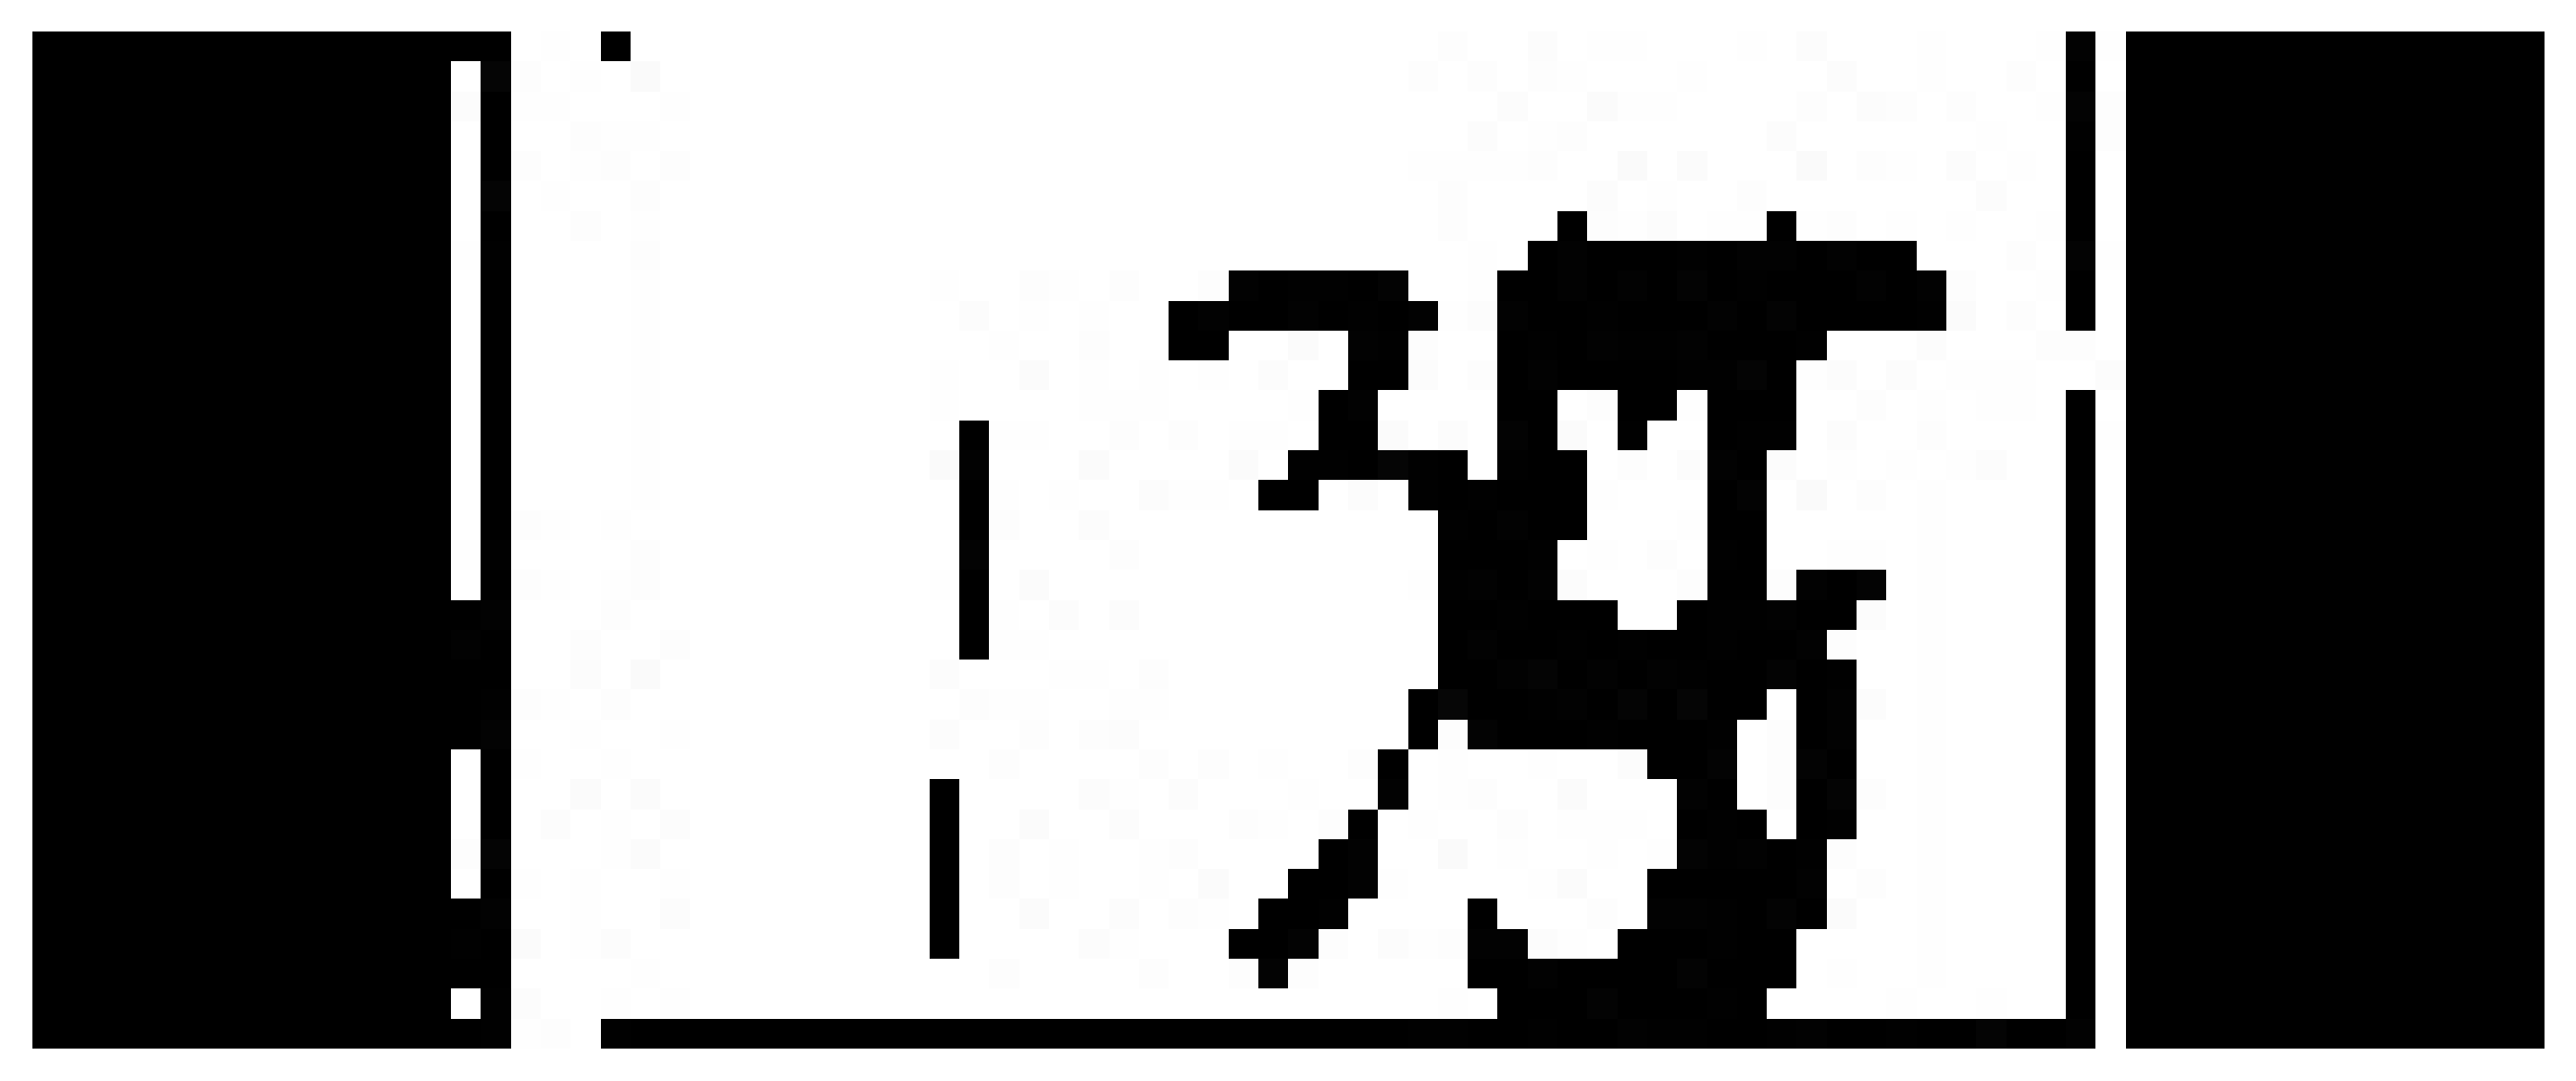

In [19]:
print('original shape in (height, width, channels):', dataset['test_images'][0].shape)
# image = cv2.resize(dataset['test_images'][1], (0,0), fx=1/2/2/2/2, fy=1/2/2/2/2)
# print(image.shape)
plt.imshow(dataset['test_images'][0], cmap='gray')
plt.axis('off')

In [20]:
import numpy as np
print('Preidction', [lib.dataloader.all_allowed_characters[idx] for idx in np.argmax(model.predict(dataset['test_images'][0][None, :, :, :]), axis=-1)[0]])
print('Ground truth', [lib.dataloader.all_allowed_characters[idx] for idx in dataset['test_targets'][0]])

Preidction ['1', '3', '5', '!', '!', '!', '!', '!']
Ground truth ['1', '3', '5', '!', '!', '!', '!', '!']


In [21]:
# obtaining feature maps and attention weights
resblock1_fm, final_fm, att_weights = model.sess.run([resblock1_output, resnet_output, attention_tensor], {
    model.inference_input_ph: dataset['test_images'][0][None, :, :, :],
    model.is_training_ph: False
})

## Visualizing feature maps

Feature map at resblock 1 has shape (34, 84, 16) — 34 pixels by 84 pixels and 16 feature dimensions

Final feature map (at resblock 7) has shape (3, 6, 256)

In [22]:
f, axes = plt.subplots(4, 4, figsize=(80, 40))
for i in range(resblock1_fm.shape[-1]):
    axes[i//4,i%4].imshow(resblock1_fm[0, :, :, i], cmap='gray')
    axes[i//4,i%4].axis('off')
    axes[i//4,i%4].set_title('fearure: %d' % (i))
# f.subplots_adjust(hspace=-0.5, wspace=0.4)
f.tight_layout()
plt.show()

In [23]:
f, axes = plt.subplots(16, 16, figsize=(80, 40))
for i in range(final_fm.shape[-1]):
    axes[i//16,i%16].imshow(final_fm[0, :, :, i], cmap='gray')
    axes[i//16,i%16].axis('off')
    axes[i//16,i%16].set_title('fearure: %d' % (i))
# f.subplots_adjust(hspace=-0.5, wspace=0.4)
f.tight_layout()

### ! After 4 times down-sampling, the feature maps have become too small to visualize any meaningful features.

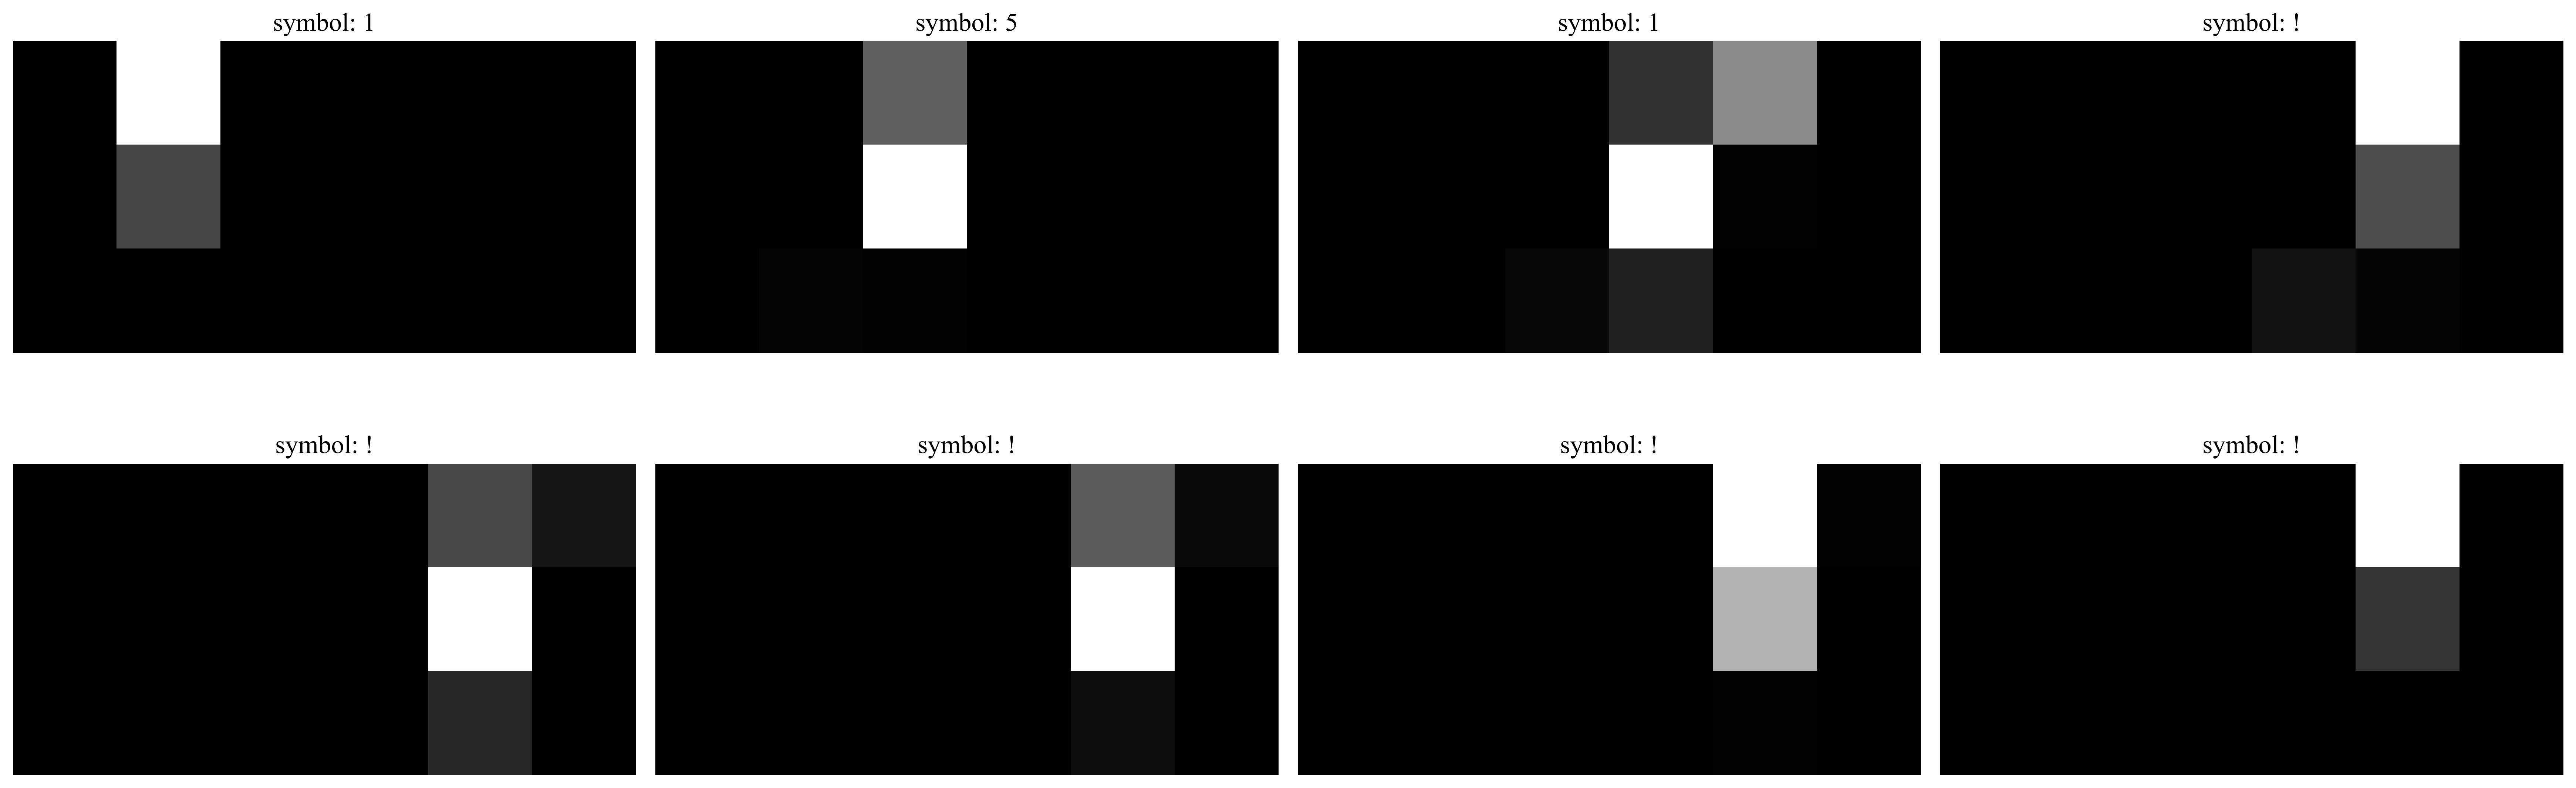

In [24]:
f, axes = plt.subplots(2, 4, figsize=(20,10))
for i in range(att_weights.shape[1]):
    axes[i//4,i%4].imshow(att_weights[0, i, :].reshape(6,3).T, cmap='gray')
    axes[i//4,i%4].axis('off')
    axes[i//4,i%4].set_title('symbol: ' + lib.dataloader.all_allowed_characters[dataset['test_targets'][1][i]])
f.subplots_adjust(hspace=-0.5, wspace=0.4)
f.tight_layout()